<i><b>Public AI</b></i>

# Guided Grad-CAM 구현하기


### _Objective_

* Grad-CAM을 통해 우리는 이미지의 어떤 영역이 중요한지를 히트맵을 통해 시각화할 수 있지만, 상세한 이미지의 특성을 잡아내긴 어렵습니다.
* Guided Backpropagation을 이용하면, 명확한 이미지의 특성 및 윤곽을 확인할 수 있습니다.

In [7]:
%matplotlib inline
import os
import cv2
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import get_file

## 예제 이미지) 

이번에는 강아지와 레서판다 이미지를 통해, Class Activation Map을 시각화해보도록 하겠습니다.

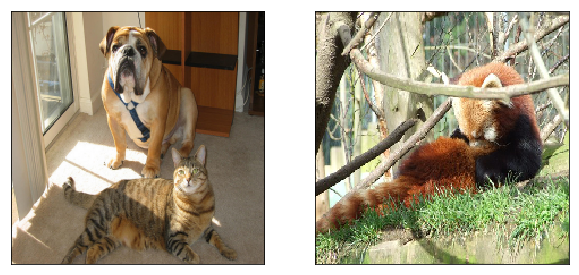

In [8]:
# 이미지 시각화하기 
dog_path = get_file("cat_and_dog.png",
                    "https://raw.githubusercontent.com/jacobgil/keras-grad-cam/master/examples/cat_dog.png")
dog_image = Image.open(dog_path)
dog_image = np.array(dog_image.resize((224,224)))

panda_path = get_file("redpanda.jpg",
                      "https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/redpanda.jpg")
panda_image = Image.open(panda_path)
panda_image = np.array(panda_image.resize((224,224)))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(dog_image)
ax.set_xticks([]); ax.set_yticks([])
ax = fig.add_subplot(1,2,2)
ax.imshow(panda_image)
ax.set_xticks([]); ax.set_yticks([])
plt.show()

<br><br>

# \[ Guided Grad-CAM \]
----

Guided Grad-CAM은 Grad-CAM으로 얻어진 Heat Map과 Guided BackPropagation으로 얻어진 Heat Map을 결합한 시각화 방법론입니다.<br>

<br>


## 1. Guided Back Propagation 이란? 

* Guided Backpropagation은 *Striving For Simplicity: The All Convolution Net*에서 제안한 시각화 방법론입니다.<br>
* Gradient을 활용하여 영상 내에서 어떤 요소가 유의미한지를 판단하는 기법으로, 높은 해상도의 정보로 구체적인 시각 형태를 잡아내는데 쓰입니다.<br>


![Imgur](https://i.imgur.com/pTzarAO.png)

* Guided Back Propagation의 핵심은 역전파 과정 중에서, Relu의 역전파 식을 보정하는 데에 있습니다.<br>
* Relu의 역전파 과정에서는 Input이 음수인 방향으로는 Gradient를 흘러보내지 않는데, 거기에 더해 gradient가 0인 것도 같이 안 보내게 되면 그것이 바로 Guided Back Propagation입니다.

$$
R^{l}_i = (f^{i}_i>0)\cdot(R_i^{i+1}>0)\cdot R^{l+1}_i
$$

* Guided Backpropagation은 양수의 Gradient만 이미지 재구축에 참여하게 함으로써, 좀 더 깔끔한 이미지로 재구축을 할 수 있습니다.

<br>

## 2. Guided BackPropagation 연산자 구현하기

* Tensorflow에서는 각 연산자 별 역전파 수식이 이미 결정되어 있습니다.<br>
* 이를 변경하기 위해서는, 새로운 역전파 수식을 구현해서 덮어씌어 주어야 합니다. <br>
* 아래의 코드를 통해, guidedRelu라는 새로운 역전파 코드를 작성하고, 그것을 relu에 덮어씌우는 방식으로 진행하였습니다. <br>

reference : [stackoverflow : How to replace or modify gradient](https://stackoverflow.com/questions/43839431/tensorflow-how-to-replace-or-modify-gradient)

In [11]:
import tensorflow as tf
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import get_custom_objects

In [12]:
@tf.custom_gradient
def guidedrelu(x):
    a = tf.maximum(x,0.)
    def grad(dy):
        relu_mask = tf.cast(x > 0., tf.float32)
        guided_mask = tf.cast(dy > 0., tf.float32)
        return dy * guided_mask * relu_mask
    return a, grad

get_custom_objects().update({'relu':guidedrelu})

## 3. Guided GradCAM 구현하기

* grad CAM에 guided_backprop를 곱해줌으로써, 우리는 높은 해상도를 가진 Class Activation Map을 얻을 수 있습니다.

### (1) VGG 모델 가져오기

In [14]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.models import Model

vgg19 = VGG19()

In [15]:
fmap = vgg19.get_layer('block5_conv4').output # 마지막 Convolution Layer 가져오기
output = vgg19.get_layer('predictions').output# 출력층 가져오기

grad_model = Model(vgg19.input, [fmap, output])

### (2) Guided-Grad CAM 부분 구현하기

In [7]:
image = (dog_image - [123.68,116.779,103.939,])
image = tf.constant(image, tf.float32)

# TODO

In [25]:
@tf.function
def get_guided_cam(image):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(image)
        conv_outputs, model_outputs = grad_model(image[None])

        top_indices = tf.argmax(model_outputs, axis=1)
        top_logit = tf.gather(model_outputs, top_indices, axis=1)

    grads = tape.gradient(top_logit, conv_outputs)
    channel_importance = tf.reduce_mean(grads, axis=[1,2],
                                        keepdims=True)
    heat_map = tf.reduce_sum(channel_importance * conv_outputs, 
                             axis=-1, keepdims=True)
    heat_map = tf.nn.relu(heat_map)

    heat_map = tf.image.resize(heat_map, image.shape[:2])

    saliency_map = tape.gradient(top_logit, image)
    guided_heat_map = saliency_map * heat_map
    
    return model_outputs, heat_map[0], saliency_map, guided_heat_map

<br>

## 4. 실제 이미지에 적용하기


### (1) 강아지 사진에 시각화하기

In [26]:
image = dog_image - [123.68,116.779,103.939,]
image = image.astype(np.float32)

prediction, h_value, s_value, g_value = get_guided_cam(image)
predicted_label = decode_predictions(prediction.numpy())[0]

In [27]:
h_value = np.squeeze(h_value) # (1,H,W,1) -> (H,W)
s_value = np.squeeze(s_value) # (1,H,W,C) -> (H,W,C)
g_value = np.squeeze(g_value) # (1,H,W,C) -> (H,W,C)

norm_s_value = (s_value - s_value.min())/(s_value.max() - s_value.min())
norm_g_value = (g_value - g_value.min())/(g_value.max() - g_value.min())

result : ('n02129604', 'tiger', 0.28177777)


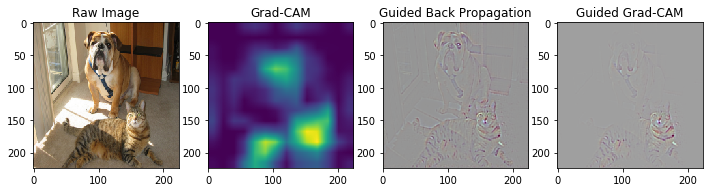

In [30]:
print(f"result : {predicted_label[0]}")
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,4,1)
ax.set_title("Raw Image")
ax.imshow(dog_image)

ax = fig.add_subplot(1,4,2)
ax.set_title("Grad-CAM")
ax.imshow(h_value)

ax = fig.add_subplot(1,4,3)
ax.set_title("Guided Back Propagation")
ax.imshow(norm_s_value)

ax = fig.add_subplot(1,4,4)
ax.set_title("Guided Grad-CAM")
ax.imshow(norm_g_value)

plt.show()

### (2) 판다 사진에 시각화하기

In [31]:
image = panda_image - [123.68,116.779,103.939,]
image = image.astype(np.float32)

prediction, h_value, s_value, g_value = get_guided_cam(image)
predicted_label = decode_predictions(prediction.numpy())[0]

In [32]:
h_value = np.squeeze(h_value) # (1,H,W,1) -> (H,W)
s_value = np.squeeze(s_value) # (1,H,W,C) -> (H,W,C)
g_value = np.squeeze(g_value) # (1,H,W,C) -> (H,W,C)

norm_s_value = (s_value - s_value.min())/(s_value.max() - s_value.min())
norm_g_value = (g_value - g_value.min())/(g_value.max() - g_value.min())

result : ('n02509815', 'lesser_panda', 0.28985718)


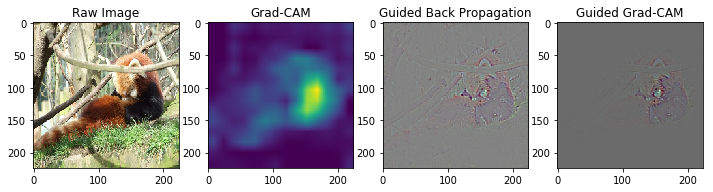

In [35]:
print(f"result : {predicted_label[0]}")
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,4,1)
ax.set_title("Raw Image")
ax.imshow(panda_image)

ax = fig.add_subplot(1,4,2)
ax.set_title("Grad-CAM")
ax.imshow(h_value)

ax = fig.add_subplot(1,4,3)
ax.set_title("Guided Back Propagation")
ax.imshow(norm_s_value)

ax = fig.add_subplot(1,4,4)
ax.set_title("Guided Grad-CAM")
ax.imshow(norm_g_value)

plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/16

---